In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [39]:
def generate_mask(p, q, prob):
    omega = np.round(0.5 * (np.random.random((p, q)) + prob))
    return torch.tensor(omega).bool()

In [40]:
def generate_templates(p, q, K):
    Tk_flat, _ = torch.linalg.qr(torch.randn(p * q, K))
    Tk = [Tk_flat[:, k].reshape(p, q) for k in range(K)]
    return Tk

In [53]:
def plot(errors):
    plt.figure(figsize=(8, 6))
    plt.xlabel("iteration")
    plt.ylabel("error")
    plt.plot(range(1, len(errors) + 1), errors)
    plt.grid()

    plt.show()

In [57]:
# Параметры задачи
p, q, r, K = 100, 30, 5, 600
sigma = 0.1
mu_o = 0.05
mu = 0.01
eta = 0.001
num_epochs = 500
prob_obs = 0.3  

In [43]:
# Генерация X
G_Q = torch.randn(p, r)                
Q_true, R_tmp = torch.linalg.qr(G_Q)    
sign = torch.sign(torch.diag(R_tmp)).unsqueeze(0)
Q_true.mul_(sign) 

G_R = torch.randn(r, q)
R_true = torch.triu(G_R)                
diag_sign = torch.sign(torch.diag(R_true))
R_true.mul_(diag_sign.unsqueeze(1))

X_true = Q_true @ R_true

In [44]:
Tk = generate_templates(p, q, K)

In [45]:
# Генерация  Y
Omega = generate_mask(p, q, prob_obs)
noise = sigma * torch.randn(p, q)
Y = torch.zeros(p, q)
Y[Omega] = (X_true + noise)[Omega]
Zk = torch.tensor([torch.sum(Y * T) for T in Tk])

In [68]:
Q, _ = torch.linalg.qr(torch.randn(p, r))
R = torch.triu(torch.randn(r, q))
z = torch.randn(K, requires_grad=True)
Q.requires_grad_(True)
R.requires_grad_(True)

tri_mask = torch.triu(torch.ones_like(R))

# Оптимизация
optimizer = torch.optim.Adam([Q, R, z], lr=eta)
errors = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    z_pred = torch.tensor([torch.sum((Q @ R) * T) for T in Tk])
    loss_z = 0.5 * torch.sum((Zk - z)**2)
    loss_fit = 0.5 * torch.sum((z - z_pred)**2)

    orth_penalty = (mu_o**2 / 2) * torch.norm(Q.T @ Q - torch.eye(r))**2
    reg_R = mu**2 / 2 * torch.norm(R - R_true)**2

    loss = loss_z + loss_fit + orth_penalty + reg_R

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        Q_proj, R_tmp = torch.linalg.qr(Q)   
        sign = torch.sign(torch.diag(R_tmp)).unsqueeze(0)
        Q.copy_(Q_proj * sign)

        R.mul_(tri_mask)                       


    if epoch % 50 == 0 or epoch == num_epochs - 1:
        
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    errors.append(torch.norm(Q @ R - X_true).detach().item())


# errors.append(np.linalg.norm(U @ L @ V.T - X_0, ord='fro')/np.linalg.norm(X_0, ord='fro'))

X_rec = Q @ R


Epoch 0, Loss: 705.8328
Epoch 50, Loss: 654.3763
Epoch 100, Loss: 606.9610
Epoch 150, Loss: 563.2693
Epoch 200, Loss: 522.9251
Epoch 250, Loss: 485.6104
Epoch 300, Loss: 451.0575
Epoch 350, Loss: 419.0343
Epoch 400, Loss: 389.3354
Epoch 450, Loss: 361.7772
Epoch 499, Loss: 336.6871


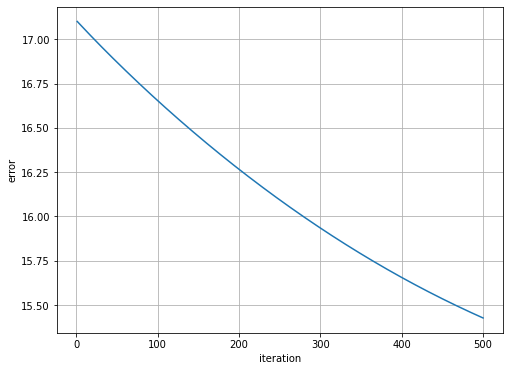

In [69]:
plot(errors)

In [64]:
X_rec = Q @ R
print("Final reconstruction error:", torch.norm(X_rec - X_true).item())

Final reconstruction error: 20.19129753112793
